# Modeling

In this notebook, our aims is to find an accurate model for our data. With this model, we can find business solutions about house prices. 

To do this, we have some steps;
- Discover linearity , collinearity between columns
- Discover highly correlated columns with price
- Decide the metric for models 
- Try different transformations, regressions, scalers, models
- According to our metric,compare them and find the best models 
- Guess some specific models such as special for zipcodes

# Importing Necessary Libraries

In [1]:
# Array and Dataframe
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Statistical and modeling libraries
import scipy.stats as stats
import math
import random

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import quantile_transform, QuantileTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

from pygam import LinearGAM

import gc; gc.enable()

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('clean_data.csv') # to take our clean data to date frame

In [3]:
df.drop(columns='Unnamed: 0',inplace=True) # to get rid of unnecessary extra column

In [4]:
pd.options.display.max_columns=100 # to see all columns

# First Look for Correlations

To develop a model, correlations are very important. Because, highly correlated columns affect prices. To invest, which columns are very important in our data, we plot correlation matrix. 

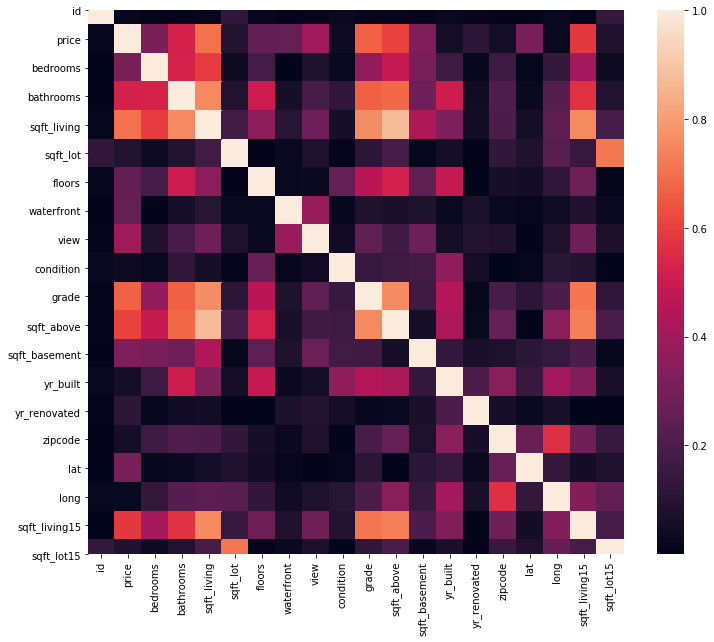

In [5]:
plt.figure(figsize = (12,10))
sns.heatmap(df.corr().abs())    # To see the correlations
plt.show() 

Also, we want to see numeric values. To do this and also use for modelling, we divided our target column 'price' from whole data set.

In [6]:
target = "price"
used_cols = [c for c in df.columns.to_list() if c not in [target]] # all columns except price

# assign all columns except price new df as X and 'price' is y
X = df[used_cols]
y = df[target]

In [7]:
df.corr()[target].abs().sort_values(ascending=False) #to see the numeric values for correlations

price            1.000000
sqft_living      0.701587
grade            0.668307
sqft_above       0.605695
sqft_living15    0.585304
bathrooms        0.525053
view             0.395734
sqft_basement    0.321816
bedrooms         0.315229
lat              0.307868
waterfront       0.259220
floors           0.257052
yr_renovated     0.117982
sqft_lot         0.090338
sqft_lot15       0.083189
yr_built         0.054273
zipcode          0.053620
condition        0.035393
long             0.022417
id               0.017392
Name: price, dtype: float64

# First Step to Baseline Determination for Model

First of all, we need to decide our baseline. In this notebook, we will use pipeline for modeling steps. Because, we will try different transformations, scalers etc. to find the best results. So, we created pipeline and use this pipeline generally. 

Out metric is R^2 for this project. Just to see errors , we also find negative mean squared errors. But we will decide our model according to R^2. Because R^2 shows that how close the data is to the fitted regression and our model.

To get a good results, we use cross validation. We choose cv as 3, it gives 3 different results for each trial. We get and use mean of them. This application will give us more accurate results. Instead of train-test splits, we prefer cross validation which splitting train-test itself and do it for 3 times. 

For the first trial we use Robust Scaler as a scaler. Robust scales variables using statistics that are strong to outliers. In our dataset, we have many outliers. If we clean all of them, we can lose lots of data points. Instead of dropping all of them, firstly we scale them. Robust Scaler use IQR(Interquartile Range) and the interquartile range generally give better results fot these type of data.

In [8]:
# Linear Regression with pipeline

scaler = RobustScaler()    
lr = LinearRegression()
pipe1 = make_pipeline(scaler, lr)

metrics = ['r2', 'neg_mean_squared_error'] # we will use R2 as metric generally
    
c_v = cross_validate(pipe1, X, y, cv=3, n_jobs=-1, scoring=metrics,return_train_score=True)

In [9]:
sorted(c_v.keys()) # to reach the our results, because c_v gives dictionary

['fit_time',
 'score_time',
 'test_neg_mean_squared_error',
 'test_r2',
 'train_neg_mean_squared_error',
 'train_r2']

To see the results we write a function for printing. 

In [10]:
def print_results (c_v):
    test = c_v['test_r2'].mean()  
    train= c_v['train_r2'].mean()  
    
    print (f'test r2 is {test}')
    print (f'train r2 is {train}')

    test_MSE = c_v['test_neg_mean_squared_error'].mean()  
    train_MSE = c_v['train_neg_mean_squared_error'].mean() 

    print (f'test NEG MSE is {test_MSE}')
    print (f'train NEG MSE is {train_MSE}')
    
    return c_v

In [11]:
print_results(c_v)

test r2 is 0.6954963579543829
train r2 is 0.7014500841259426
test NEG MSE is -40758506733.6965
train NEG MSE is -39993008512.35435


{'fit_time': array([0.04383993, 0.04409981, 0.04031324]),
 'score_time': array([0.00828314, 0.00740409, 0.00561881]),
 'test_r2': array([0.69825846, 0.69247075, 0.69575986]),
 'train_r2': array([0.70065807, 0.70398594, 0.69970625]),
 'test_neg_mean_squared_error': array([-4.13376855e+10, -4.02826672e+10, -4.06551676e+10]),
 'train_neg_mean_squared_error': array([-3.96562794e+10, -4.00822592e+10, -4.02404870e+10])}

Also we created new dataframe to see all trials and compare them.

In [12]:
df_results = pd.DataFrame(columns=["Model", "Info",'Test R^2','Train R^2','Pseudo R^2']) # to see all results 

In [13]:
df_results = df_results.append({       # first trial is written in results 
     "Model": 'Linear Regression' ,
      "Info": 'All columns' , 
       'Test R^2' : 0.6955,
        'Train R^2' : 0.7014,
            'Pseudo R^2' : '-'}, ignore_index=True)

For the first simple trial, we find our R^2 values near to each other. Nearest train and test data R^2 values means better results. But our general R^2 is not very near to 1. So, we continue to improve it.

### Changing Scaler

In [14]:
scaler = MinMaxScaler()    
lr = LinearRegression()
pipe2 = make_pipeline(scaler, lr)

c_v2 = cross_validate(pipe2, X, y, cv=3, n_jobs=-1, scoring=metrics,return_train_score=True)

In [15]:
print_results(c_v2)

test r2 is 0.6954963579543834
train r2 is 0.7014500841259427
test NEG MSE is -40758506733.696434
train NEG MSE is -39993008512.35433


{'fit_time': array([0.0193553 , 0.04300117, 0.03723288]),
 'score_time': array([0.00389695, 0.00963402, 0.01230121]),
 'test_r2': array([0.69825846, 0.69247075, 0.69575986]),
 'train_r2': array([0.70065807, 0.70398594, 0.69970625]),
 'test_neg_mean_squared_error': array([-4.13376855e+10, -4.02826672e+10, -4.06551676e+10]),
 'train_neg_mean_squared_error': array([-3.96562794e+10, -4.00822592e+10, -4.02404870e+10])}

We check our results with using MinMax Scaler and there is no significant change. So, we continue to scale our data with RobustScaler which is more suitable to our outliers.

## Let’s Dig Deeper on 'sq_ft living'

Square_ft living area is our most related column with prices. So, we deep into for exploring features.

In [16]:
df['sqft_living'].describe()

count    21534.000000
mean      2079.827854
std        917.446520
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

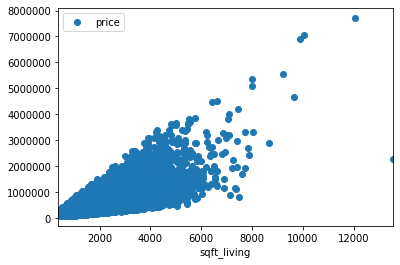

In [17]:
df.plot(x='sqft_living', y='price',style='o')

It is easily seen that there is positive linear correlation between price and living area. 

From the graph we can understand that there are some outliers such as area is higher than 13000 but lower price.
This column is the most related column with our target. So , we decided to clean some rows which has higher area than 
8000 sqft. We choose 8000 because generally our data points are belower than this value.

In [18]:
df1 = df[df['sqft_living'] < 8000] # we do not want to change our raw dataframe so assigning new one.

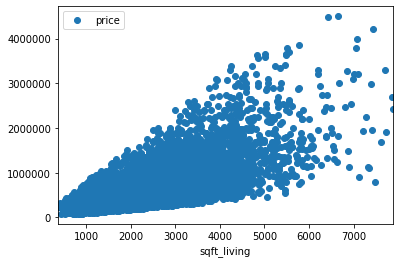

In [19]:
df1.plot(x='sqft_living', y='price',style='o')

Now, we have more good spread data.

In [20]:
target = "price"
used_cols = [c for c in df1.columns.to_list() if c not in [target]] # all columns except price

# assign all columns except price new df as X and 'price' is y
X1 = df1[used_cols]
y1 = df1[target]

scaler = RobustScaler()    
lr = LinearRegression()
pipe3 = make_pipeline(scaler, lr)

c_v3 = cross_validate(pipe3, X1, y1, cv=3, n_jobs=-1, scoring=metrics,return_train_score=True)

In [21]:
print_results(c_v3)

test r2 is 0.7003383486337086
train r2 is 0.7059533828205039
test NEG MSE is -36849724118.42468
train NEG MSE is -36175444458.317024


{'fit_time': array([0.05208397, 0.05307698, 0.05620003]),
 'score_time': array([0.0103929 , 0.00971389, 0.00490713]),
 'test_r2': array([0.70774434, 0.69879616, 0.69447455]),
 'train_r2': array([0.70296984, 0.70734129, 0.70754902]),
 'test_neg_mean_squared_error': array([-3.54914034e+10, -3.47625145e+10, -4.02952545e+10]),
 'train_neg_mean_squared_error': array([-3.67861471e+10, -3.71034271e+10, -3.46367592e+10])}

We run our model with new dataframe without living area < 8000 sqft. And find better results from previous when we drop the outliers of most correlated column.

In [22]:
df_results = df_results.append({       # keeping the results in result_df
     "Model": 'Linear Regression' ,
      "Info": 'All col. without >8000 sq_ft' , 
       'Test R^2' : 0.7003,
        'Train R^2' : 0.7059,
            'Pseudo R^2' : '-'}, ignore_index=True)

# Deep Into 'grade' Columns

Grade column is the second correlated column with prices. So, we will do some differences on it and try to understand effect of these differences. Firstly, we look at our column to understand general tendency.

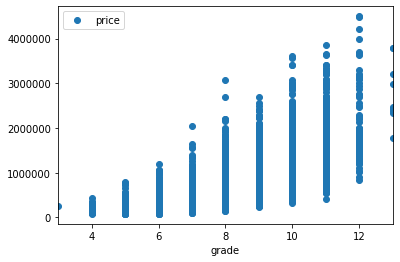

In [23]:
df1.plot(x='grade', y='price', style='o')

In [24]:
df1['grade'].value_counts()

7     8948
8     6053
9     2604
6     2031
10    1130
11     395
5      242
12      84
4       27
13       9
3        1
Name: grade, dtype: int64

From the first look, we understood that many of houses has 7 grades, 13 is very less and 3 is just one house.
But we want to check median prices for houses according to grades. To do this, we create a pivot table and graph.

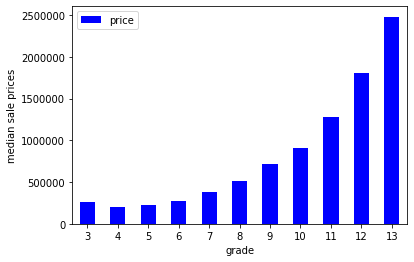

In [25]:
grade_pivot = df1.pivot_table(index='grade', values='price', aggfunc=np.median) # crating pivot table for median

grade_pivot.plot(kind='bar', color='blue')
plt.xlabel('grade')
plt.ylabel('median sale prices')
plt.xticks(rotation=0)
plt.show()


Median prices for 13 is significantly higher than others. So, we decided to encode this columns, and try model again.
Because it is the second correlated column with our prices. With adding new encoded column, our R^2 can change.

In [26]:
# We want to keep our dataframes in each step to come back easily. So , assing new data frame and we will use it

df2 = df1.copy()

In [27]:
def encode(x):    # assign 1 for 13, for others assign 0
    return 1 if x == 13 else 0

df2['enc_grade'] = df2['grade'].apply(encode)
 

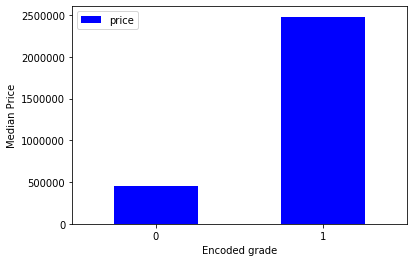

In [28]:
# to see encoded plot
grade_pivot = df2.pivot_table(index='enc_grade', values='price', aggfunc=np.median)
grade_pivot.plot(kind='bar', color='blue')
plt.xlabel('Encoded grade')
plt.ylabel('Median Price')
plt.xticks(rotation=0)
plt.show()

In [29]:
used_cols2 = [c for c in df2.columns.to_list() if c not in [target]]

X2 = df2[used_cols2]
y2 = df2[target]

pipe4 = make_pipeline(scaler, lr)
    
c_v4 = cross_validate(pipe4, X2, y2, cv=3, n_jobs=-1, scoring=metrics,return_train_score=True)

In [30]:
print_results(c_v4)

test r2 is 0.7027535380265387
train r2 is 0.7086357560892281
test NEG MSE is -36555763996.1179
train NEG MSE is -35846136563.54593


{'fit_time': array([0.06778216, 0.08039403, 0.08205295]),
 'score_time': array([0.01512814, 0.00916696, 0.00768185]),
 'test_r2': array([0.71016636, 0.70173481, 0.69635944]),
 'train_r2': array([0.70562563, 0.70979625, 0.71048539]),
 'test_neg_mean_squared_error': array([-3.51972743e+10, -3.44233585e+10, -4.00466592e+10]),
 'train_neg_mean_squared_error': array([-3.64572368e+10, -3.67921860e+10, -3.42889869e+10])}

In [31]:
df_results = df_results.append({       # keeping the results in result_df
     "Model": 'Linear Regression' ,
      "Info": 'with encoded grade w/o >8000 sq_ft' , 
       'Test R^2' : 0.7028,
        'Train R^2' : 0.7086,
            'Pseudo R^2' : '-'}, ignore_index=True)

When we dropped outliers of sqft living and encoded grade, we found better results than baseline. So, we can continue to upgrade.

In [32]:
df3 = df2.copy()

df3.drop(columns=['sqft_above','sqft_basement'],inplace=True)

# These two columns affects our total sqft because of multicollinearity. So, we dropped them and try again. 

In [33]:
used_cols3 = [c for c in df3.columns.to_list() if c not in [target]]

X3 = df3[used_cols3]
y3 = df3[target]

pipe5 = make_pipeline(scaler, lr)
    
c_v5 = cross_validate(pipe5, X3, y3, cv=3, n_jobs=-1, scoring=metrics,return_train_score=True)
print_results(c_v5)

test r2 is 0.7025401330629494
train r2 is 0.7081429625050298
test NEG MSE is -36581577713.15112
train NEG MSE is -35906707867.25291


{'fit_time': array([0.04844904, 0.05809212, 0.04805017]),
 'score_time': array([0.00894785, 0.01283407, 0.01354885]),
 'test_r2': array([0.70933072, 0.70184016, 0.69644952]),
 'train_r2': array([0.70541117, 0.70914193, 0.70987579]),
 'test_neg_mean_squared_error': array([-3.52987543e+10, -3.44112005e+10, -4.00347784e+10]),
 'train_neg_mean_squared_error': array([-3.64837973e+10, -3.68751408e+10, -3.43611855e+10])}

In [34]:
df_results = df_results.append({       # keeping the results in result_df
     "Model": 'Linear Regression' ,
      "Info": 'with enc_grade, w/o >8000ft w/o sqft_above&basement',
       'Test R^2' : 0.7025,
        'Train R^2' : 0.7081,
            'Pseudo R^2' : '-'}, ignore_index=True)

There is no significant difference with these columns or without these columns. So,we decided not to drop them in this stage. So, we can use previous dataframe.

# Binning for Forcing Monotonicity and Linearity

Monotonic relation between variables are important also. So, we try to establish monotonic relationship between X and y values. The way of doing this is Binning. Here, we will divide our data into bins and replace this values with average value of target. It forces our data to monotonicity.

But in this concept, bounds are very important. We can easily extrapolate outside of the bounds. 


In [35]:
from sklearn.preprocessing import KBinsDiscretizer
from category_encoders import TargetEncoder, OneHotEncoder

In [36]:
binner = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile') # we choose bins as 8
binner.fit_transform(X1, y1)  # choose our X,y values from df1 

# with fit.transform, we setting parameters, fitting and scaling them.

array([[5., 2., 1., ..., 3., 1., 2.],
       [5., 2., 3., ..., 2., 3., 4.],
       [5., 1., 1., ..., 3., 6., 4.],
       ...,
       [1., 1., 0., ..., 2., 0., 0.],
       [0., 2., 4., ..., 6., 1., 0.],
       [1., 1., 0., ..., 2., 0., 0.]])

The binner returns as an array. We need to fix it to use in pipeline as dataframe. Here, we will use KBinsDf Class from our Instructor's notebook about Intro to GLMS classes.

In [37]:
class KBinsDf(KBinsDiscretizer):
    """
    DataFrame-compatible k-bins discretizer.
    """
    def __init__(self, n_bins=8, strategy='quantile', tag='BINNED'):
        self.n_bins = n_bins
        self.strategy = strategy
        super(KBinsDf, self).__init__(n_bins=self.n_bins, encode='ordinal', strategy=self.strategy)
        self.tag = tag

    def transform(self, X1, y=None, override_return_df=False):
        z = super(KBinsDf, self).transform(X1)
        
        # Append suffix to strings in list 
        columns = [str(c) + "_" + self.tag for c in X1.columns.tolist()] 
        
        return pd.DataFrame(z, index=X1.index, columns=columns)
    
    def get_feature_names(self):
        return X1.columns.tolist()

# we changed code as 8 bins which we decided in KBinsDiscretizer and changed the class according to our X,y values.

Now, we will use this class to find our binned X dataframe.

In [38]:
binner = KBinsDf(n_bins=8, strategy='quantile')
X1_binned = binner.fit_transform(X1, y1)
X1_binned.head()

,id_BINNED,bedrooms_BINNED,bathrooms_BINNED,sqft_living_BINNED,sqft_lot_BINNED,floors_BINNED,waterfront_BINNED,view_BINNED,condition_BINNED,grade_BINNED,sqft_above_BINNED,sqft_basement_BINNED,yr_built_BINNED,yr_renovated_BINNED,zipcode_BINNED,lat_BINNED,long_BINNED,sqft_living15_BINNED,sqft_lot15_BINNED
0,5.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,7.0,2.0,3.0,1.0,2.0
1,5.0,2.0,3.0,6.0,3.0,2.0,0.0,0.0,1.0,1.0,5.0,1.0,2.0,0.0,6.0,7.0,2.0,3.0,4.0
2,5.0,1.0,1.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,7.0,3.0,6.0,4.0
3,2.0,3.0,5.0,4.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,3.0,3.0,0.0,6.0,2.0,0.0,1.0,1.0
4,1.0,2.0,2.0,3.0,4.0,0.0,0.0,0.0,1.0,2.0,4.0,0.0,5.0,0.0,4.0,4.0,6.0,3.0,3.0


Now, we will add encoder to our pipeline. TargetEncoder encodes data for categorical features.
It is one of Bayesian Encoders and taking steps to avoid overfitting or response leakage. Smarter way to encode categorical data.
We already binned our data, so we can use encoder in pipeline.
First we use KBinsDF class to fit our results to df.

In [39]:
binner = KBinsDf()
encoder = TargetEncoder(cols=[c+"_BINNED" for c in used_cols])

pipe6 = make_pipeline(binner, encoder, lr)

c_v6 = cross_validate(pipe6, X1, y1, cv=3, n_jobs=-1, scoring=metrics,return_train_score=True)
print_results(c_v6)


test r2 is 0.6234776878631169
train r2 is 0.6276870612945866
test NEG MSE is -46327584580.03948
train NEG MSE is -45783308152.29474


{'fit_time': array([0.88834906, 0.85618043, 0.81594801]),
 'score_time': array([0.15446806, 0.15151691, 0.15116715]),
 'test_r2': array([0.62096013, 0.63381187, 0.61566107]),
 'train_r2': array([0.63455929, 0.63006977, 0.61843212]),
 'test_neg_mean_squared_error': array([-4.60304413e+10, -4.22624761e+10, -5.06898363e+10]),
 'train_neg_mean_squared_error': array([-4.52585540e+10, -4.68999522e+10, -4.51914182e+10])}

We did not find better results than before, so we decided continue without binner and encoder.

In [40]:
df_results = df_results.append({       # keeping the results in result_df
     "Model": 'Linear Regression' ,
      "Info": 'with binner and target encoder',
       'Test R^2' : 0.6235 ,
        'Train R^2' : 0.6277,
            'Pseudo R^2' : '-'}, ignore_index=True)

# One-Hot Encoding

Already, we tried two  feature engineering concepts as target encoding and binning. Another common way is to encoding categorical data is called One-Hot Encoding. One-hot encoding changes categorical variables as binary vectors.
We think that it will NOT give us better results but just make sure and to see the results we also try one-hot encoding. 

We are using pipeline. So, new trials are easy steps.

In [41]:
binner = KBinsDf()
encoder = OneHotEncoder(cols=[c+"_BINNED" for c in used_cols])

pipe7 = make_pipeline(binner, encoder, lr)

c_v7 = cross_validate(pipe7, X1, y1, cv=3, n_jobs=-1, scoring=metrics,return_train_score=True)
print_results(c_v7)

test r2 is 0.6831704438116488
train r2 is 0.6887394731957305
test NEG MSE is -38998906092.08709
train NEG MSE is -38284643687.019035


{'fit_time': array([1.4731009 , 1.41345811, 1.41209316]),
 'score_time': array([0.60985518, 0.59058309, 0.63457298]),
 'test_r2': array([0.68261847, 0.69377929, 0.67311356]),
 'train_r2': array([0.69194477, 0.68916124, 0.68511241]),
 'test_neg_mean_squared_error': array([-3.85426780e+10, -3.53415202e+10, -4.31125200e+10]),
 'train_neg_mean_squared_error': array([-3.81515638e+10, -3.94083035e+10, -3.72940638e+10])}

As we expected, it did not give better results. 

In [42]:
df_results = df_results.append({       # keeping the results in result_df
     "Model": 'Linear Regression' ,
      "Info": 'with binner and one-hot encoder',
       'Test R^2' : 0.6832 ,
        'Train R^2' : 0.6887,
            'Pseudo R^2' : '-'}, ignore_index=True)

## Transforming Data 

Now, we try to transform our data. Normal distribution is very important for models. We will use Quantile Transform to use quantile information in our transforming. This method transforms our data to follow normal distribution. This transform reduces effects of outliers because it focus on quantiles. This transform is non-linear. It can break linear correlations. 

With using this method, we assume normal distribution. 

In [43]:
X_transformed = pd.DataFrame(quantile_transform(X1, n_quantiles=20,  # binned quantiles 
                                                output_distribution='normal', 
                                                random_state=42), 
                             columns=used_cols)

X_transformed.head()    # to see the transformed dataframe

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0.607335,-0.336038,-1.252120,-1.101506,-0.513412,-5.199338,-5.199338,-5.199338,-0.406724,-0.479506,-0.704369,-5.199338,-0.554923,-5.199338,1.642538,-0.445052,-0.085338,-1.030514,-0.512696
1,0.446100,-0.336038,0.066012,0.690751,-0.118923,0.804596,-5.199338,-5.199338,-0.406724,-0.479506,0.641338,0.490922,-0.699547,3.226360,0.855373,1.188697,-0.591201,-0.249943,0.003288
2,0.334556,-1.412188,-1.252120,-1.795367,0.556125,-5.199338,-5.199338,-5.199338,-0.406724,-1.412188,-1.717274,-5.199338,-1.127221,-5.199338,-0.835371,1.427873,0.007157,1.066239,0.160742
3,-0.523515,0.716498,1.252120,0.054978,-0.704369,-5.199338,-5.199338,-5.199338,5.199338,-0.479506,-1.030806,1.178502,-0.253347,-5.199338,1.047787,-0.389392,-1.646198,-0.976236,-0.734487
4,-0.745040,-0.336038,-0.132313,-0.294441,0.129840,-5.199338,-5.199338,-5.199338,-0.406724,0.406724,0.150484,-5.199338,0.371149,-5.199338,0.066012,0.236126,1.083835,-0.066012,-0.049675


We saw transformed dataframe, now do it in our natural pipeline.

In [44]:
transformer = QuantileTransformer(n_quantiles=20, output_distribution='normal', random_state=42)
pipe8 = make_pipeline(transformer, lr)

c_v8 = cross_validate(pipe8, X1, y1, cv=3, n_jobs=-1, scoring=metrics,return_train_score=True)
print_results(c_v8)


test r2 is 0.5890658457601349
train r2 is 0.5969428090696506
test NEG MSE is -50586392525.19956
train NEG MSE is -49592347905.35056


{'fit_time': array([0.16875911, 0.17592812, 0.15760326]),
 'score_time': array([0.08188176, 0.09145284, 0.09109402]),
 'test_r2': array([0.60134163, 0.59532348, 0.57053243]),
 'train_r2': array([0.58955309, 0.59891975, 0.60235558]),
 'test_neg_mean_squared_error': array([-4.84129040e+10, -4.67044946e+10, -5.66417790e+10]),
 'train_neg_mean_squared_error': array([-5.08324150e+10, -5.08491676e+10, -4.70954611e+10])}

We found worse results than our baseline. It means when we are trying to force our data to normalization we lose information. So, we will not continue this method.

In [45]:
df_results = df_results.append({       # keeping the results in result_df
     "Model": 'Linear Regression' ,
      "Info": 'with quantile transformer',
       'Test R^2' : 0.5891 ,
        'Train R^2' : 0.5969,
            'Pseudo R^2' : '-'}, ignore_index=True)

# Lasso and Ridge Regression

We have large number of features. Ridge and Lasso regressions are simple regressions to reduce model complexity and prevent over-fitting which may result from simple linear regression. Now, we will try this methods.

## Lasso

In [46]:
lasso = Lasso(alpha=0.001)      
pipe9 = make_pipeline(scaler, lasso)
c_v9 = cross_validate(pipe9, X1 , y1, cv=3, n_jobs=-1, scoring=metrics,return_train_score=True)

print_results(c_v9)

test r2 is 0.7003383485286503
train r2 is 0.7059533828205021
test NEG MSE is -36849724113.073456
train NEG MSE is -36175444458.31727


{'fit_time': array([1.05460906, 1.07377195, 1.04973888]),
 'score_time': array([0.02015615, 0.01065803, 0.00421906]),
 'test_r2': array([0.70774434, 0.69879616, 0.69447455]),
 'train_r2': array([0.70296984, 0.70734129, 0.70754902]),
 'test_neg_mean_squared_error': array([-3.54914038e+10, -3.47625147e+10, -4.02952539e+10]),
 'train_neg_mean_squared_error': array([-3.67861471e+10, -3.71034271e+10, -3.46367592e+10])}

We run our code with different alpha values and write them in our result dataframe. None of them gave us better results. Most probably, our model is complex and reducing complexity is not working.

In [47]:
df_results = df_results.append({       # keeping the results in result_df
     "Model": 'Lasso Regression' ,
      "Info": 'alpha = 0.1',
       'Test R^2' : 0.7003 ,
        'Train R^2' : 0.7060,
            'Pseudo R^2' : '-'}, ignore_index=True)

In [48]:
df_results = df_results.append({       # keeping the results in result_df
     "Model": 'Lasso Regression' ,
      "Info": 'alpha = 0.001',
       'Test R^2' : 0.7003 ,
        'Train R^2' : 0.7060,
            'Pseudo R^2' : '-'}, ignore_index=True)

In [49]:
df_results = df_results.append({       # keeping the results in result_df
     "Model": 'Lasso Regression' ,
      "Info": 'alpha = 1000',
       'Test R^2' : 0.6985 ,
        'Train R^2' : 0.7043,
            'Pseudo R^2' : '-'}, ignore_index=True)

## Ridge

In [50]:
ridge = Ridge(alpha=0.001)
pipe10 = make_pipeline(scaler, ridge)

c_v10 = cross_validate(pipe10, X1 , y1, cv=3, n_jobs=-1, scoring=metrics,return_train_score=True)
print_results(c_v10)

test r2 is 0.7003383583736582
train r2 is 0.7059533828182728
test NEG MSE is -36849722285.59986
train NEG MSE is -36175444458.58965


{'fit_time': array([0.04172683, 0.04349518, 0.05217695]),
 'score_time': array([0.00772309, 0.01284313, 0.00566101]),
 'test_r2': array([0.70774424, 0.69879612, 0.69447471]),
 'train_r2': array([0.70296984, 0.70734129, 0.70754902]),
 'test_neg_mean_squared_error': array([-3.54914157e+10, -3.47625186e+10, -4.02952325e+10]),
 'train_neg_mean_squared_error': array([-3.67861471e+10, -3.71034271e+10, -3.46367592e+10])}

We run our code with different alpha values and write them in our result dataframe. None of them gave us better results.

In [51]:
df_results = df_results.append({       # keeping the results in result_df
     "Model": 'Ridge Regression' ,
      "Info": 'alpha = 0.1',
       'Test R^2' : 0.7003 ,
        'Train R^2' : 0.7060,
            'Pseudo R^2' : '-'}, ignore_index=True)

In [52]:
df_results = df_results.append({       # keeping the results in result_df
     "Model": 'Ridge Regression' ,
      "Info": 'alpha = 0.001',
       'Test R^2' : 0.7003 ,
        'Train R^2' : 0.7060,
            'Pseudo R^2' : '-'}, ignore_index=True)

In [53]:
df_results = df_results.append({       # keeping the results in result_df
     "Model": 'Ridge Regression' ,
      "Info": 'alpha = 1000',
       'Test R^2' : 0.6854 ,
        'Train R^2' : 0.6899,
            'Pseudo R^2' : '-'}, ignore_index=True)

In [54]:
df_results

,Model,Info,Test R^2,Train R^2,Pseudo R^2
0,Linear Regression,All columns,0.6955,0.7014,-
1,Linear Regression,All col. without >8000 sq_ft,0.7003,0.7059,-
2,Linear Regression,with encoded grade w/o >8000 sq_ft,0.7028,0.7086,-
3,Linear Regression,"with enc_grade, w/o >8000ft w/o sqft_above&bas...",0.7025,0.7081,-
4,Linear Regression,with binner and target encoder,0.6235,0.6277,-
5,Linear Regression,with binner and one-hot encoder,0.6832,0.6887,-
6,Linear Regression,with quantile transformer,0.5891,0.5969,-
7,Lasso Regression,alpha = 0.1,0.7003,0.7060,-
8,Lasso Regression,alpha = 0.001,0.7003,0.7060,-
9,Lasso Regression,alpha = 1000,0.6985,0.7043,-


When we checked our values, we could not find better results than 0.7 R^2. So, we decided to try Generalized Linear Models.

# Generalized Linear Models

## (GAMs) Generalized Additive Models

GAMs model gives us powerful statistical learning with interpretability, flexibility, and regularization. Our model contains nonlinear effects. We need strong balance with these three features. We need flexible but linear model, so we used GAMs.

First, we used LinearGAM with normal distribution.

In [56]:
gam = LinearGAM(n_splines=25)
gam.gridsearch(X1.values, y1.values)
gam.summary()


100% (11 of 11) |########################| Elapsed Time: 0:00:38 Time:  0:00:38


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    299.3708
Link Function:                     IdentityLink Log Likelihood:                               -531251.9618
Number of Samples:                        21524 AIC:                                          1063104.6652
                                                AICc:                                          1063113.196
                                                GCV:                                      21433602240.8118
                                                Scale:                                    20897670673.3412
                                                Pseudo R-Squared:                                   0.8325
Feature Function                  Lam

In [71]:
df_results = df_results.append({       # keeping the results in result_df
     "Model": 'GAMs' ,
      "Info": 'normal dist',
       'Test R^2' : '-' ,
        'Train R^2' : '-',
            'Pseudo R^2' : '0.8325'}, ignore_index=True)

Our results are better than baseline and all other regressions. Now, we will change distribution from linear to gamma distribution.

In [57]:
# Changing distribution assumption to gamma and link function to log
from pygam import GAM


gam = GAM(distribution='gamma', link='log')
gam.gridsearch(X1.values, y1.values)
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:59 Time:  0:00:59


GAM                                                                                                       
=============================================== ==========================================================
Distribution:                         GammaDist Effective DoF:                                    235.7016
Link Function:                          LogLink Log Likelihood:                               -275295.6171
Number of Samples:                        21524 AIC:                                           551064.6375
                                                AICc:                                          551069.9239
                                                GCV:                                                0.0359
                                                Scale:                                              0.0356
                                                Pseudo R-Squared:                                   0.8828
Feature Function                  Lam

For gamma distribution and log as a link function, we get better results as R^2 equal 0.8828. So, we decided to play around this distribution.

In [72]:
df_results = df_results.append({       # keeping the results in result_df
     "Model": 'GAMs' ,
      "Info": 'gamma dist',
       'Test R^2' : '-' ,
        'Train R^2' : '-',
            'Pseudo R^2' : '0.8828'}, ignore_index=True)

In [66]:
# import needed libraries for tensor ,spline and factor

from pygam.terms import s as spline
from pygam.terms import f as factor
from pygam.terms import te as tensor


Now, we try to play around lattitude and longtitude columns and getting together them with tensor. Tensor is used for any interaction between columns.

In [65]:
# longtitude and lattitude columns are 15th and 16th. So we will use tensor (15,16).

# now we will create list with all variables and added them our tensor variable (15,16)

term_list = []
for i, col in enumerate(used_cols):
    term_list.append(spline(i))

# add the 'lat' and 'long' interaction term
term_list.append(tensor(15, 16))

# create the terms and model
terms = np.sum(term_list)
print(terms)
gam = GAM(terms=terms,distribution='gamma', link='log').gridsearch(X1.values, y1.values)
gam.summary()


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + te(15, 16)


100% (11 of 11) |########################| Elapsed Time: 0:01:19 Time:  0:01:19


GAM                                                                                                       
=============================================== ==========================================================
Distribution:                         GammaDist Effective DoF:                                    283.2374
Link Function:                          LogLink Log Likelihood:                                -273091.611
Number of Samples:                        21524 AIC:                                           546751.6968
                                                AICc:                                          546759.3314
                                                GCV:                                                0.0295
                                                Scale:                                              0.0291
                                                Pseudo R-Squared:                                   0.9044
Feature Function                  Lam

In [83]:
df_results = df_results.append({       # keeping the results in result_df
     "Model": 'GAMs' ,
      "Info": 'gamma dist with tensor',
       'Test R^2' : '-' ,
        'Train R^2' : '-',
            'Pseudo R^2' : '0.9044'}, ignore_index=True)

Now, we try to drop id column which do not have interaction with prices. And run the model again with same tensor and distribution.

In [75]:
df_without_id = df1.copy() #creating new df to protect original one.

In [77]:
df_without_id.drop(columns='id',inplace=True) #drop id columns

In [79]:
# assign new columns to df
target = "price"
used_cols_new = [c for c in df_without_id.columns.to_list() if c not in [target]] # all columns except price

# assign all columns except price new df as X and 'price' is y
X_new = df_without_id[used_cols_new]
y_new = df_without_id[target]

In [82]:
# longtitude and lattitude columns are 14th and 15th. So we will use tensor (14,15).

# now we will create list with all variables and added them our tensor variable (14,15)

term_list = []
for i, col in enumerate(used_cols_new):
    term_list.append(spline(i))

# add the 'lat' and 'long' interaction term
term_list.append(tensor(14, 15))

# create the terms and model
terms = np.sum(term_list)
print(terms)
gam = GAM(terms=terms,distribution='gamma', link='log').gridsearch(X_new.values, y_new.values)
gam.summary()


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + te(14, 15)


100% (11 of 11) |########################| Elapsed Time: 0:01:08 Time:  0:01:08


GAM                                                                                                       
=============================================== ==========================================================
Distribution:                         GammaDist Effective DoF:                                     264.282
Link Function:                          LogLink Log Likelihood:                               -273135.4712
Number of Samples:                        21524 AIC:                                           546801.5063
                                                AICc:                                          546808.1523
                                                GCV:                                                0.0295
                                                Scale:                                              0.0293
                                                Pseudo R-Squared:                                    0.904
Feature Function                  Lam

In [84]:
df_results = df_results.append({       # keeping the results in result_df
     "Model": 'GAMs' ,
      "Info": 'w/o id, gamma dist with tensor',
       'Test R^2' : '-' ,
        'Train R^2' : '-',
            'Pseudo R^2' : '0.9040'}, ignore_index=True)

We did not get better results than before. So, we decided our model with gamma distribution and with log as a link function using lattitude and longtitude tensor.

In [85]:
df_results

,Model,Info,Test R^2,Train R^2,Pseudo R^2
0,Linear Regression,All columns,0.6955,0.7014,-
1,Linear Regression,All col. without >8000 sq_ft,0.7003,0.7059,-
2,Linear Regression,with encoded grade w/o >8000 sq_ft,0.7028,0.7086,-
3,Linear Regression,"with enc_grade, w/o >8000ft w/o sqft_above&bas...",0.7025,0.7081,-
4,Linear Regression,with binner and target encoder,0.6235,0.6277,-
5,Linear Regression,with binner and one-hot encoder,0.6832,0.6887,-
6,Linear Regression,with quantile transformer,0.5891,0.5969,-
7,Lasso Regression,alpha = 0.1,0.7003,0.706,-
8,Lasso Regression,alpha = 0.001,0.7003,0.706,-
9,Lasso Regression,alpha = 1000,0.6985,0.7043,-


It can be seen obviously from the dataframe above that our best R^2 values , which is close to 1 is GAMs model with gamma distribution with longtitude and lattitude tensor columns. We choose this one as a model. 

 # Clean until here!!!! zipcode explorations are beginningggggg after here

In [230]:
df_gams['zipcode'].value_counts()

98103    601
98038    586
98115    580
98052    573
98117    553
        ... 
98102    103
98010    100
98024     79
98148     57
98039     48
Name: zipcode, Length: 70, dtype: int64

In [245]:
df_zip1 = df_gams.loc[df_gams['zipcode']==98103]

In [246]:
df_zip1

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,enc_grade,lat_and_long,lat_and_long_sq,lat_and_long_cubes,lat_sq,lat_cubes,long_sq
17,6865200140,485000.0,4,1.00,1600,4300,1.5,0.0,0.0,4,7,1600,0.0,1916,0.0,98103,47.6648,-122.343,1610,4300,0,-74.6782,5576.833555,-416467.891605,2271.933159,108291.239639,-1.831207e+06
111,3362400511,570000.0,3,1.75,1260,3328,1.0,0.0,0.0,5,6,700,560.0,1905,0.0,98103,47.6823,-122.349,1380,3536,0,-74.6667,5575.116089,-416275.520474,2273.601733,108410.559927,-1.831476e+06
116,3362400431,518500.0,3,3.50,1590,1102,3.0,0.0,0.0,3,8,1590,0.0,2010,0.0,98103,47.6824,-122.347,1620,3166,0,-74.6646,5574.802493,-416240.398231,2273.611270,108411.242009,-1.831386e+06
128,2331300505,822500.0,5,3.50,2320,4960,2.0,0.0,0.0,5,7,1720,600.0,1926,0.0,98103,47.6763,-122.352,1700,4960,0,-74.6757,5576.460170,-416426.066753,2273.029582,108369.640246,-1.831611e+06
149,1994200024,511000.0,3,1.00,1430,3455,1.0,0.0,0.0,3,7,980,450.0,1947,0.0,98103,47.6873,-122.336,1450,4599,0,-74.6487,5572.428412,-415974.536776,2274.078581,108444.667530,-1.830892e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21551,9521100031,690000.0,3,3.25,1540,1428,3.0,0.0,0.0,3,9,1540,0.0,2013,0.0,98103,47.6648,-122.353,1660,3300,0,-74.6882,5578.327219,-416635.219016,2271.933159,108291.239639,-1.831656e+06
21558,1931300090,610950.0,3,3.00,1680,1570,3.0,0.0,0.0,3,8,1680,0.0,2014,0.0,98103,47.6572,-122.346,1640,4800,0,-74.6888,5578.416845,-416645.260086,2271.208712,108239.447822,-1.831341e+06
21576,1931300412,475000.0,3,2.25,1190,1200,3.0,0.0,0.0,3,8,1190,0.0,2008,0.0,98103,47.6542,-122.346,1180,1224,0,-74.6918,5578.864987,-416695.467854,2270.922778,108219.008230,-1.831341e+06
21579,1972201967,520000.0,2,2.25,1530,981,3.0,0.0,0.0,3,8,1480,50.0,2006,0.0,98103,47.6533,-122.346,1530,1282,0,-74.6927,5578.999433,-416710.530971,2270.837001,108212.876855,-1.831341e+06


In [247]:
used_cols_zip = [c for c in df_zip1.columns.to_list() if c not in [target]]

X_zip = df_zip1[used_cols_zip]
y_zip = df_zip1[target]

In [248]:
gam = LinearGAM(n_splines=50)
gam.gridsearch(X_zip.values, y_zip.values)
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:54 Time:  0:00:54


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    150.5901
Link Function:                     IdentityLink Log Likelihood:                                 -14353.925
Number of Samples:                          601 AIC:                                            29011.0303
                                                AICc:                                           29114.1999
                                                GCV:                                      16722677687.1775
                                                Scale:                                     9404587822.9945
                                                Pseudo R-Squared:                                   0.8391
Feature Function                  Lam

In [249]:
df_zip2 = df_gams.loc[df_gams['zipcode']==98039]

In [250]:
used_cols_zip2 = [c for c in df_zip2.columns.to_list() if c not in [target]]

X_zip2 = df_zip2[used_cols_zip2]
y_zip2 = df_zip2[target]

In [251]:
gam = LinearGAM(n_splines=50)
gam.gridsearch(X_zip2.values, y_zip2.values)
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:35 Time:  0:00:35


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     46.9802
Link Function:                     IdentityLink Log Likelihood:                                 -1073.8612
Number of Samples:                           48 AIC:                                             2243.6829
                                                AICc:                                           -2551.4164
                                                GCV:                                        321560897.6775
                                                Scale:                                     2074883107.1117
                                                Pseudo R-Squared:                                   0.9999
Feature Function                  Lam

In [252]:
df_zip3 = df_gams.loc[df_gams['zipcode']==98102]

In [253]:
used_cols_zip3 = [c for c in df_zip3.columns.to_list() if c not in [target]]

X_zip3 = df_zip3[used_cols_zip3]
y_zip3 = df_zip3[target]

In [255]:
gam = LinearGAM(n_splines=50)
gam.gridsearch(X_zip3.values, y_zip3.values)
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:37 Time:  0:00:37


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     97.4913
Link Function:                     IdentityLink Log Likelihood:                                 -2160.7503
Number of Samples:                          103 AIC:                                             4518.4831
                                                AICc:                                            10103.997
                                                GCV:                                        260449552.7503
                                                Scale:                                      514763681.0202
                                                Pseudo R-Squared:                                   0.9998
Feature Function                  Lam